# Tensor Flow Lite Training with integrated preprocessing

Found 14703 files belonging to 7 classes.
Using 11763 files for training.
Using 2940 files for validation.
Epoch 1/10
59/59 [==============================] - 28s 440ms/step - loss: 1.3761 - accuracy: 0.4856 - val_loss: 1.1335 - val_accuracy: 0.5436
Epoch 2/10
59/59 [==============================] - 30s 493ms/step - loss: 1.1334 - accuracy: 0.5409 - val_loss: 1.0384 - val_accuracy: 0.5921
Epoch 3/10
59/59 [==============================] - 31s 499ms/step - loss: 1.0482 - accuracy: 0.5728 - val_loss: 0.9744 - val_accuracy: 0.6150
Epoch 4/10
59/59 [==============================] - 30s 490ms/step - loss: 0.9913 - accuracy: 0.5903 - val_loss: 0.9348 - val_accuracy: 0.6264
Epoch 5/10
59/59 [==============================] - 30s 485ms/step - loss: 0.9450 - accuracy: 0.6162 - val_loss: 0.9047 - val_accuracy: 0.6357
Epoch 6/10
59/59 [==============================] - 30s 483ms/step - loss: 0.9102 - accuracy: 0.6321 - val_loss: 0.8951 - val_accuracy: 0.6429
Epoch 7/10
59/59 [=================

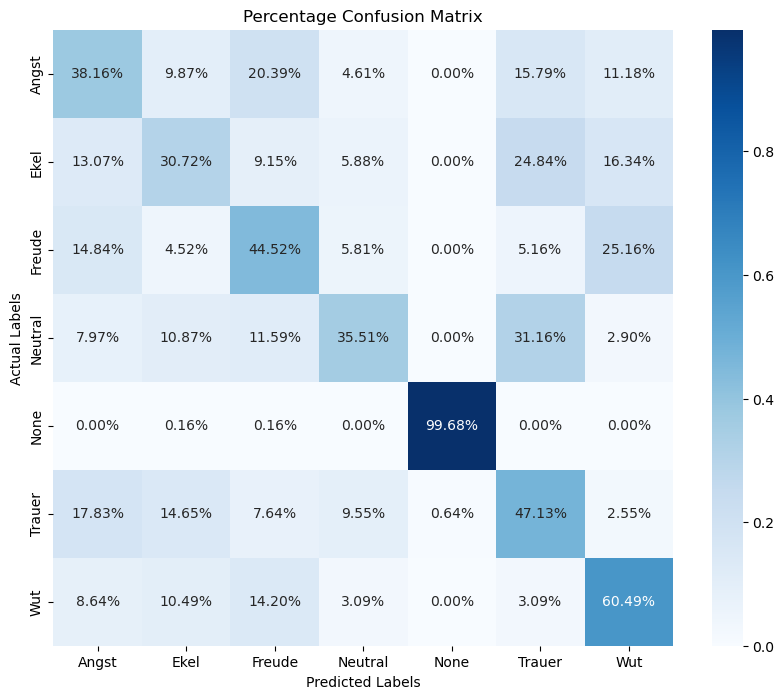

INFO:tensorflow:Assets written to: C:\Users\seraf\AppData\Local\Temp\tmplt4381tq\assets


INFO:tensorflow:Assets written to: C:\Users\seraf\AppData\Local\Temp\tmplt4381tq\assets


In [4]:
import os
import pathlib
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt  # For plotting
import seaborn as sns 

# Pfad zur Datensammlung
DATASET_PATH = "C:\\Users\\seraf\\Documents\\Schule\\Module\\PA\\TensorflowModellTest\\PA_Emotion_Modell\\Trainings und Testdaten"
data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
    raise Exception("Datenverzeichnis existiert nicht!")

# Laden der Daten
commands = np.array(['Angst', 'Ekel', 'Freude', 'Neutral', 'None', 'Trauer', 'Wut'])
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=200,
    validation_split=0.2,
    seed=42,
    output_sequence_length=48000,
    subset='both')

# Daten vorbereiten
train_ds = train_ds.map(lambda audio, label: (tf.squeeze(audio, axis=-1), label))
val_ds = val_ds.map(lambda audio, label: (tf.squeeze(audio, axis=-1), label))
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

# Mel-Spektrogramm und MFCCs direkt im Modell berechnen
class AudioPreprocessingLayer(layers.Layer):
    def __init__(self):
        super(AudioPreprocessingLayer, self).__init__()

    def call(self, waveform):
        # Normalisierung
        mean = tf.reduce_mean(waveform)
        std_dev = tf.math.reduce_std(waveform)
        normalized_waveform = (waveform - mean) / std_dev

        # Mel-Spektrogramm
        spectrogram = tf.signal.stft(normalized_waveform, frame_length=2048, frame_step=1024)
        spectrogram = tf.abs(spectrogram)
        num_spectrogram_bins = spectrogram.shape[-1]
        linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
             512, num_spectrogram_bins, 16000, 50.0, 6000.0)
        mel_spectrogram = tf.tensordot(spectrogram, linear_to_mel_weight_matrix, 1)
        mel_spectrogram.set_shape(spectrogram.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))
        
        # MFCCs
        log_mel_spectrogram = tf.math.log1p(mel_spectrogram)
        mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrogram)[..., :35]
        mfccs = spectrogram[..., :35]
        return mfccs

# Modell bauen
def build_model(input_shape, num_labels):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        AudioPreprocessingLayer(),
        layers.Reshape((45, 35, 1)),  
        layers.Conv2D(32, (5, 5), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.175),
        layers.Conv2D(128, (5, 5), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='sigmoid'),
        layers.Dropout(0.15),
        layers.Dense(num_labels, activation='softmax'),
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

input_shape = (48000, )  # ursprüngliche Wellenformlänge
num_labels = len(commands)

model = build_model(input_shape, num_labels)

# Training des Modells
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1)],
    verbose=1
)

# Model Evaluation
y_pred = model.predict(test_ds)
predicted_classes = tf.argmax(y_pred, axis=1)

# Extract true labels from test_ds
y_true = []
for _, labels in test_ds:
    y_true.append(labels.numpy())
y_true = np.concatenate(y_true)

# Convert class indices to class names (if needed)
class_names = commands  # or train_ds.class_names if available

# Create confusion matrix with class indices
confusion_mtx = tf.math.confusion_matrix(y_true, predicted_classes)

# Convert confusion matrix to percentages
confusion_mtx_percentage = confusion_mtx / tf.reduce_sum(confusion_mtx, axis=1)[:, tf.newaxis]

# Visualize confusion matrix with class names
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx_percentage, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Percentage Confusion Matrix')
plt.show()


# Konvertieren in TFLite-Modell
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Speichern des TFLite-Modells
tflite_model_path = "C:\\Users\\seraf\\Documents\\Schule\\Module\\PA\\TensorflowModellTest\\PA_Emotion_Modell\\TFLite\\model.tflite"
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

# Tensor Flow Lite Test with integrated preprocessing

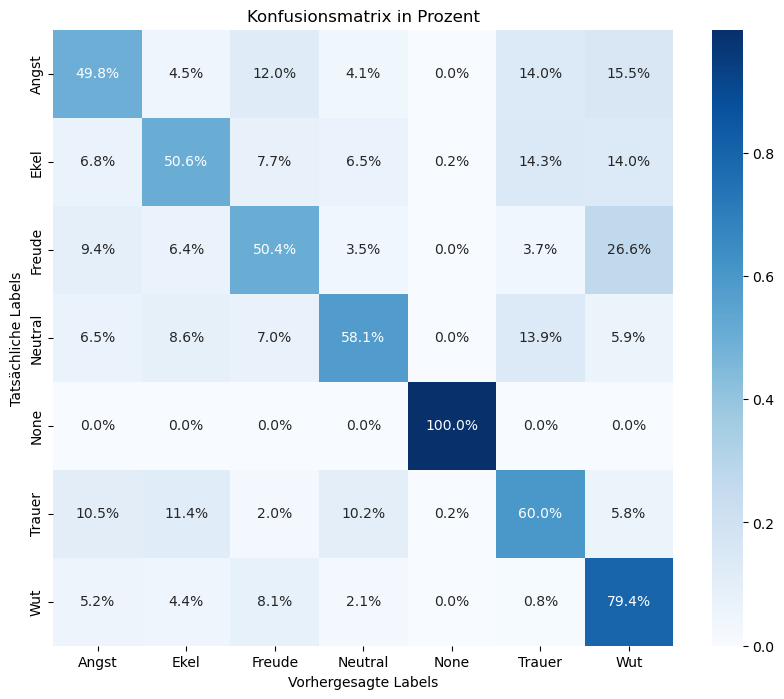

In [9]:
import os
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Pfad zur Datensammlung
DATASET_PATH = "C:\\Users\\seraf\\Documents\\Schule\\Module\\PA\\TensorflowModellTest\\PA_Emotion_Modell\\Trainings und Testdaten"
LABELS = ['Angst', 'Ekel', 'Freude', 'Neutral', 'None', 'Trauer', 'Wut']

def load_data(dataset_path, sr=16000, duration=3):
    all_waveforms = []
    all_labels = []
    max_length = sr * duration  # Maximale Länge der Waveform in Samples
    for label in LABELS:
        label_dir = os.path.join(dataset_path, label)
        for wav_file in os.listdir(label_dir):
            if wav_file.lower().endswith('.wav'):
                file_path = os.path.join(label_dir, wav_file)
                waveform, _ = tf.audio.decode_wav(tf.io.read_file(file_path))
                waveform = tf.squeeze(waveform, axis=-1)
                
                # Wellenform auf maximale Länge kürzen oder mit Nullen auffüllen
                waveform_length = tf.shape(waveform)[0]
                padding = tf.maximum(max_length - waveform_length, 0)
                zero_padding = tf.zeros([padding], dtype=tf.float32)
                waveform = tf.concat([waveform, zero_padding], 0)
                waveform = waveform[:max_length]  # Kürzen, falls länger als max_length
                
                all_waveforms.append(waveform)
                all_labels.append(LABELS.index(label))
    return np.array(all_waveforms), np.array(all_labels)

# Laden der Daten
waveforms, labels = load_data(DATASET_PATH)
# Aufteilen in Trainings- und Validierungsdatensätze
#_, X_val, _, _ = train_test_split(waveforms, labels, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(waveforms, labels, test_size=0.4, random_state=42)

# TensorFlow Lite-Modell laden
interpreter = tf.lite.Interpreter(model_path="C:\\Users\\seraf\\Documents\\Schule\\Module\\PA\\TensorflowModellTest\\PA_Emotion_Modell\\TFLite\\model.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Vorhersagen auf den Validierungsdaten
predicted_labels = []
for waveform in X_test:
    # Sicherstellen, dass die Wellenform die richtige Länge hat
    if len(waveform) > 48000:
        waveform = waveform[:48000]
    elif len(waveform) < 48000:
        waveform = np.pad(waveform, (0, 48000 - len(waveform)), 'constant')

    # Erweitern der Dimension, um die Batch-Größe zu repräsentieren
    waveform = np.expand_dims(waveform, axis=0)

    # Sicherstellen, dass die Wellenform die richtige Form hat
    if waveform.shape == (1, 48000):
        interpreter.set_tensor(input_details[0]['index'], waveform)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        predicted_label = np.argmax(output_data, axis=1)
        predicted_labels.extend(predicted_label)
    else:
        print("Fehlerhafte Wellenform-Form:", waveform.shape)

# Berechnung der Konfusionsmatrix
cm = confusion_matrix(y_test, predicted_labels)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot der Konfusionsmatrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt=".1%", cmap="Blues", xticklabels=LABELS, yticklabels=LABELS)
plt.xlabel('Vorhergesagte Labels')
plt.ylabel('Tatsächliche Labels')
plt.title('Konfusionsmatrix in Prozent')
plt.show()

# Tensor Flow Lite Training with external preprocessing

Found 14703 files belonging to 7 classes.
Using 11763 files for training.
Using 2940 files for validation.
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_5 (Reshape)         (None, 45, 35, 1)         0         
                                                                 
 conv2d_10 (Conv2D)          (None, 45, 35, 32)        832       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 22, 17, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_10 (Dropout)        (None, 22, 17, 32)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 22, 17, 128)       102528    
                                                                 
 max_pooling2

INFO:tensorflow:Assets written to: model_saved_model\assets


INFO:tensorflow:Assets written to: C:\Users\seraf\AppData\Local\Temp\tmppqgx0lw2\assets


INFO:tensorflow:Assets written to: C:\Users\seraf\AppData\Local\Temp\tmppqgx0lw2\assets


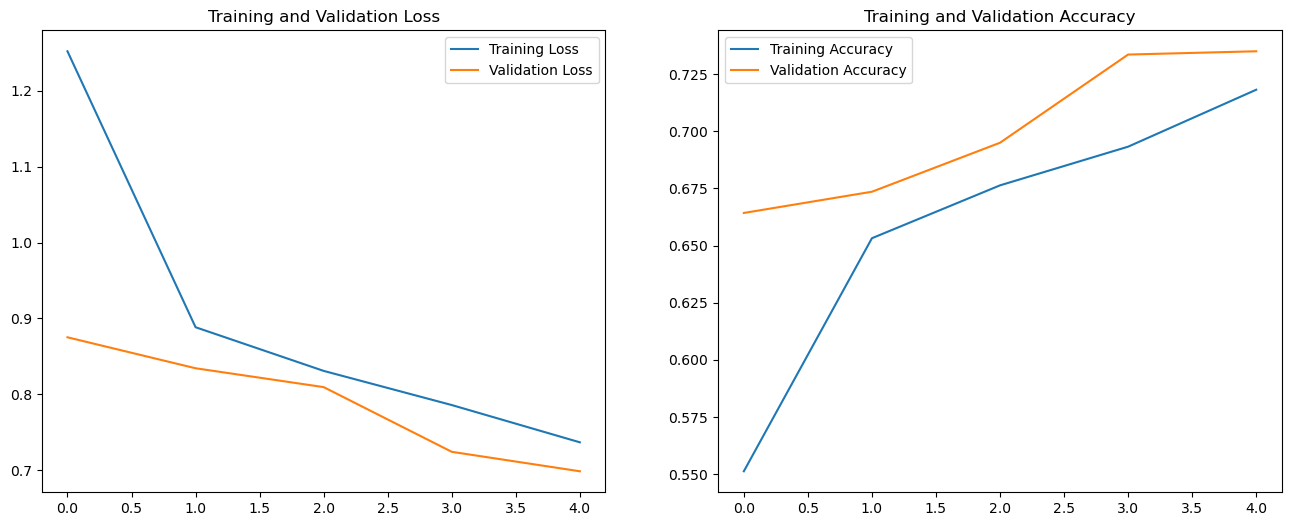

8/8 [==============================] - 2s 200ms/step


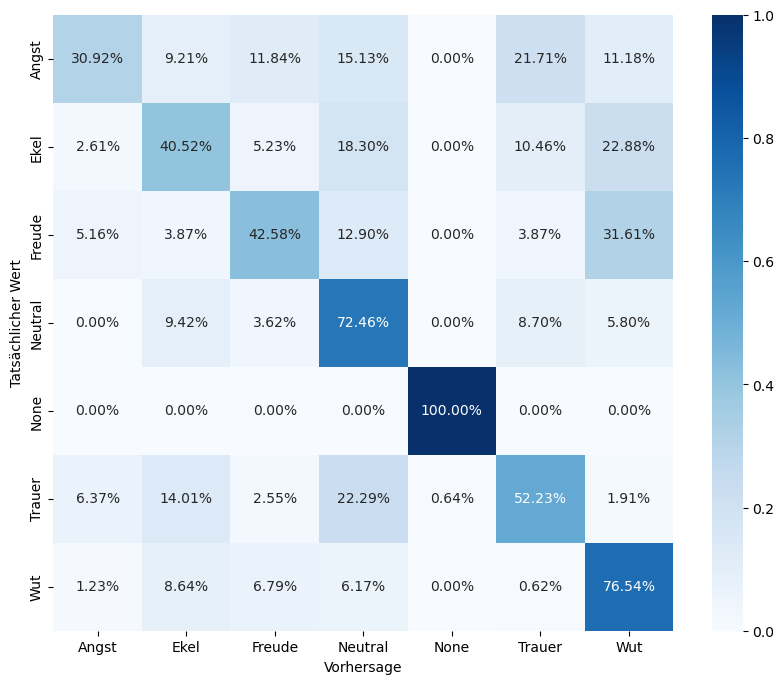

In [11]:
import os
import pathlib
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models

# Pfad zur Datensammlung
DATASET_PATH = "C:\\Users\\seraf\\Documents\\Schule\\Module\\PA\\TensorflowModellTest\\PA_Emotion_Modell\\Trainings und Testdaten"
data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
    raise Exception("Datenverzeichnis existiert nicht!")

# Laden der Daten
commands = np.array(['Angst', 'Ekel', 'Freude', 'Neutral', 'Trauer', 'Wut', 'None'])
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=200,
    validation_split=0.2,
    seed=42,
    output_sequence_length=48000,
    subset='both')

label_names = np.array(train_ds.class_names)
# Daten vorbereiten
def squeeze(audio, labels):
    return tf.squeeze(audio, axis=-1), labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

# Funktion zur Normalisierung des Audios
def normalize_audio(audio):
    mean = tf.reduce_mean(audio)
    std_dev = tf.math.reduce_std(audio)
    return (audio - mean) / std_dev

# Funktion zur Berechnung der Mel-Spektrogramme
def get_mel_spectrogram(waveform):
    spectrogram = tf.signal.stft(waveform, frame_length=2048, frame_step=1024)
    spectrogram = tf.abs(spectrogram)
    num_spectrogram_bins = spectrogram.shape[-1]
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        512, num_spectrogram_bins, 16000, 50.0, 6000.0)
    mel_spectrogram = tf.tensordot(spectrogram, linear_to_mel_weight_matrix, 1)
    mel_spectrogram.set_shape(spectrogram.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))
    return mel_spectrogram

# Funktion zur Berechnung der MFCCs
def get_mfccs(mel_spectrogram):
    log_mel_spectrogram = tf.math.log1p(mel_spectrogram)
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrogram)[..., :35]
    return mfccs

# Anwenden der Vorverarbeitung und Normalisierung auf die Datasets
def preprocess_dataset(ds):
    ds = ds.map(lambda audio, label: (normalize_audio(audio), label), num_parallel_calls=tf.data.AUTOTUNE)
    return ds.map(lambda audio, label: (get_mfccs(get_mel_spectrogram(audio)), label), num_parallel_calls=tf.data.AUTOTUNE)

train_ds = preprocess_dataset(train_ds)
val_ds = preprocess_dataset(val_ds)
test_ds = preprocess_dataset(test_ds)

# Modell bauen
def build_model(input_shape, num_labels):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Reshape((45, 35, 1)),
        layers.Conv2D(32, (5, 5), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.175),
        layers.Conv2D(128, (5, 5), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='sigmoid'),
        layers.Dropout(0.15),
        layers.Dense(num_labels, activation='softmax'),
    ])

    model.summary()
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Festlegen der Input-Shape und der Anzahl der Klassen
input_shape = (45, 35)  # Zeitframes und Anzahl der MFCC-Koeffizienten
num_labels = len(commands)  # Anzahl der Klassifikationskategorien

# Erstellen des Modells
model = build_model(input_shape, num_labels)

# Training des Modells
EPOCHS = 5  # Anzahl der Epochen
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1)],
    verbose=1
)

# Speichern des Modells im SavedModel-Format (.keras)
model.save('model_saved_model')

# Laden des SavedModel-Formats
loaded_model = tf.keras.models.load_model('model_saved_model')

# Konvertieren des geladenen Modells in TensorFlow Lite Format
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
converter.optimizations = []
tflite_model = converter.convert()

# Speichern des TFLite-Modells in einer Datei
tflite_model_path = "C:\\Users\\seraf\\Documents\\Schule\\Module\\PA\\TensorflowModellTest\\PA_Emotion_Modell\\TFLite\\model.tflite"
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

# Visualisierung des Trainingsverlaufs
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, history.history['loss'], label='Training Loss')
plt.plot(history.epoch, history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.epoch, history.history['accuracy'], label='Training Accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Modell evaluieren
y_pred = model.predict(test_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat([y for x, y in test_ds], axis=0)

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
confusion_mtx = tf.cast(confusion_mtx, dtype=tf.float32)  # Konvertieren zu float für Division
sum_by_row = tf.reduce_sum(confusion_mtx, axis=1)  # Summe jeder Zeile
confusion_mtx_percentage = tf.divide(confusion_mtx, tf.reshape(sum_by_row, [-1, 1]))  # Normalisieren

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx_percentage,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='.2%', cmap='Blues')  # Formatierung als Prozent
plt.xlabel('Vorhersage')
plt.ylabel('Tatsächlicher Wert')
plt.show()